# Introduction

The goal of this project is to create a machine learning model that is able to predict when a particular issue will reach the status 'Resolved', regardless of the current status. In order to predict a certain date time, we first need to predict the time (in days) that a issue will take. 

Subsequently we can add the predicted days to the date the issue was created to get the resolution date time. 

Since we basically need to predict the amount of days an issue will take, we are dealing with a prediction of a continuous outcome, i.e. regression analysis.

# Roadmap

In order to create such a regressor, we perform the following steps:

    Import libraries and read data
    
    Preprocessing and exproratory data analysis (EDA):
    1. Handle missing data and datatypes
    2. Checking for outliers
    3. Feature extraction and scaling (log-transforming and standardizing)
    4. Feature selection
    5. Encoding categorical data
    7. Split train - test data
    
    Learning:
    8. Train ML (regressor) models
    9. Select performance metrics
    10. Hyperparamater optimization
    11. Cross-validation
    
    Evaluation:
    12. Compare models and pick best one
    
    Prediction:
    13. Make predictions based on new data
    
    

# Import libraries

In [356]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn 
import warnings
from math import *
warnings.filterwarnings('ignore')
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100) 

# 1. Preprocessing and EDA

## Read and merge data

We will only work with 'avro-transitions.csv' and 'avro-daycounts.csv'

In [357]:
df_transitions = pd.read_csv('avro-transitions.csv')
df_daycounts = pd.read_csv('avro-daycounts.csv')
df_json = pd.read_json('avro-issues.json',lines=True)

We will take a closer look at the different dataframes so see their shapes, datatypes and missing values.

In [358]:
df_transitions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6260 entries, 0 to 6259
Data columns (total 24 columns):
status                    6260 non-null object
updated                   6260 non-null object
from_status               4094 non-null object
reporter                  6260 non-null object
when                      6260 non-null object
days_in_from_status       4094 non-null float64
who                       6260 non-null object
to_status                 6260 non-null object
assignee                  4977 non-null object
key                       6260 non-null object
description_length        5974 non-null float64
summary_length            6260 non-null int64
days_in_current_status    6260 non-null float64
days_since_open           4094 non-null float64
project                   6260 non-null object
created                   6260 non-null object
transition                6260 non-null object
resolutiondate            5412 non-null object
comment_count             6260 non-null int6

In [359]:
df_transitions.describe()

,days_in_from_status,description_length,summary_length,days_in_current_status,days_since_open,comment_count,vote_count,watch_count
count,4094.000000,5974.000000,6260.000000,6260.000000,4094.000000,6260.000000,6260.000000,6260.000000
mean,53.687721,642.830264,52.152875,2027.239254,87.182320,6.663419,0.211342,2.260863
std,156.839412,1028.241389,20.607589,928.712810,215.741525,8.101468,1.016040,2.857678
min,0.000031,15.000000,8.000000,2.025295,0.000072,0.000000,0.000000,0.000000
25%,0.566558,162.000000,37.000000,1371.454933,1.012025,2.000000,0.000000,0.000000
50%,8.271514,319.000000,50.000000,2262.267312,16.038566,4.000000,0.000000,1.000000
75%,42.216723,697.000000,64.000000,2873.232207,76.983925,8.000000,0.000000,3.000000
max,2175.533870,17439.000000,186.000000,3288.421399,2221.827884,97.000000,36.000000,74.000000


There are 6260 rows with 24 columns in the transition dataframe. There are some columns that have missing values. We will deal with these missing values later.

In [144]:
df_daycounts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19812 entries, 0 to 19811
Data columns (total 3 columns):
day       19812 non-null object
status    19812 non-null object
count     19812 non-null int64
dtypes: int64(1), object(2)
memory usage: 464.4+ KB


The daycounts dataframe contains 19812 rows with just three columns. There are seem to be no missing values in this dataframe. 

In [145]:
df_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2166 entries, 0 to 2165
Data columns (total 13 columns):
_id               2166 non-null object
changelog         2166 non-null object
editmeta          2166 non-null object
expand            2166 non-null object
fields            2166 non-null object
id                2166 non-null int64
key               2166 non-null object
names             2166 non-null object
operations        2166 non-null object
renderedFields    2166 non-null object
schema            2166 non-null object
self              2166 non-null object
transitions       2166 non-null object
dtypes: int64(1), object(12)
memory usage: 220.1+ KB


The dataframe created out of a JSON file contains 2166 rows and 13 columns of which none have missing values.

----------------------------------------------------------------------------

Now that we had a sneak peak of the dataframes, we will now take a closer look how the actual data looks like.

### df_transitions 

In [361]:
df_transitions.head(3)

,status,updated,from_status,reporter,when,days_in_from_status,who,to_status,assignee,key,description_length,summary_length,days_in_current_status,days_since_open,project,created,transition,resolutiondate,comment_count,priority,vote_count,issue_type,watch_count,resolution
0,In Progress,2018-04-21T15:44:36.749+0000,NaN,rlenferink,2018-04-17T21:53:05.730+0000,NaN,rlenferink,Open,rlenferink,AVRO-2171,233.0,43,4.643606,NaN,AVRO,2018-04-17T21:53:05.730+0000,Non-existent to Open,NaN,1,Major,0,Improvement,1,NaN
1,In Progress,2018-04-21T15:44:36.749+0000,Open,rlenferink,2018-04-18T01:33:49.088+0000,0.153280,busbey,Patch Available,rlenferink,AVRO-2171,233.0,43,4.643606,0.153280,AVRO,2018-04-17T21:53:05.730+0000,Open to Patch Available,NaN,1,Major,0,Improvement,1,NaN
2,In Progress,2018-04-21T15:44:36.749+0000,Patch Available,rlenferink,2018-04-21T15:44:36.753+0000,3.590829,busbey,In Progress,rlenferink,AVRO-2171,233.0,43,4.643606,3.744109,AVRO,2018-04-17T21:53:05.730+0000,Patch Available to In Progress,NaN,1,Major,0,Improvement,1,NaN


Since we are interested in predicting when an issue will reach the status 'Resolved', we will first create a new dataframe where the column 'to_status' is equal to 'Resolved'.

In [362]:
# Create new dataframe called 'df' where to_status == Resolved
df = df_transitions[df_transitions['to_status'] == 'Resolved']

Based on the domain knowledge of this problem, issues with the resolution "Won't Fix", "Cannot reproduce" and "Incomplete" can take months and even years, because the remain on the backlog. We are basically only interested in issue that were actually resolvable.

Therefore we will filter our new dataframe where the resolution is not equal to one of these three types. 

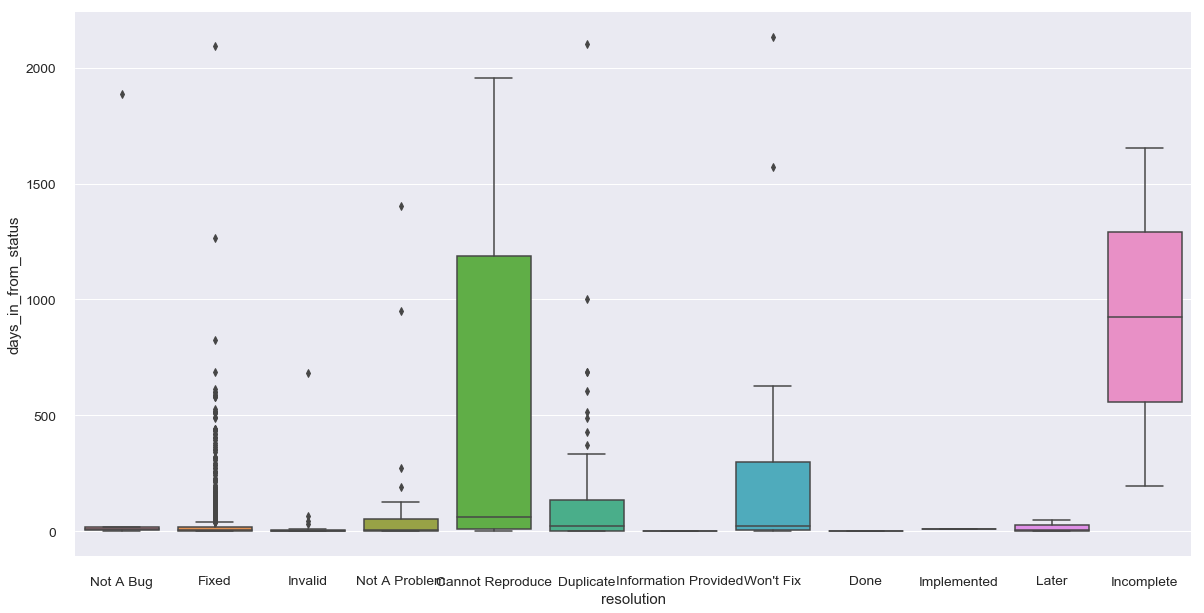

In [363]:
# Boxplot of the month and days_in_from_status
plt.figure(figsize=(20,10))
sns.boxplot(x="resolution", y="days_in_from_status",
            data=df)
sns.despine(offset=10, trim=True)

In [364]:
# Create new dataframe where resolution != "Won't Fix", "Cannot reproduce" or "Incomplete"
df = df[(df['resolution'] != 'Cannot Reproduce') & (df['resolution'] != 'Incomplete') & (df['resolution'] != "Won't Fix")]

In [365]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1505 entries, 7 to 6258
Data columns (total 24 columns):
status                    1505 non-null object
updated                   1505 non-null object
from_status               1505 non-null object
reporter                  1505 non-null object
when                      1505 non-null object
days_in_from_status       1505 non-null float64
who                       1505 non-null object
to_status                 1505 non-null object
assignee                  1303 non-null object
key                       1505 non-null object
description_length        1432 non-null float64
summary_length            1505 non-null int64
days_in_current_status    1505 non-null float64
days_since_open           1505 non-null float64
project                   1505 non-null object
created                   1505 non-null object
transition                1505 non-null object
resolutiondate            1498 non-null object
comment_count             1505 non-null int6

The new dataframe only has 1505 rows. This is the dataframe we are going to work with to create a predictive model.

Before we will continue, we will first create a new feature: days an issue already exists 'days_existing'. 
We will create this feature 'days_existing' by extracting the days_in_from_status - days_since_open.

In [367]:
df['days_existing'] = df['days_since_open'] - df['days_in_from_status']

In [368]:
df.describe()

,days_in_from_status,description_length,summary_length,days_in_current_status,days_since_open,comment_count,vote_count,watch_count,days_existing
count,1505.000000,1432.000000,1505.000000,1505.000000,1505.000000,1505.000000,1505.000000,1505.000000,1505.000000
mean,42.217062,631.329609,51.598671,2059.745038,75.358721,6.828571,0.165449,2.219934,33.141659
std,141.924865,1077.699782,20.653222,935.693926,215.102251,8.044828,0.778622,2.677750,158.682727
min,0.000065,15.000000,8.000000,2.025295,0.000781,0.000000,0.000000,0.000000,0.000000
25%,0.890803,158.000000,37.000000,1371.454997,1.362181,3.000000,0.000000,0.000000,0.000000
50%,4.111384,309.000000,49.000000,2367.524460,8.055642,5.000000,0.000000,1.000000,0.002767
75%,19.868742,666.500000,63.000000,2946.597744,42.879181,8.000000,0.000000,4.000000,2.165634
max,2102.243352,17439.000000,186.000000,3207.348112,2221.827884,84.000000,9.000000,33.000000,2175.533870


## Handling wrong datatypes 

Some of the columns have incorrect datatypes, e.g. 'updated' is a string and should be a datetime.

Therfore we will correct the incorrect datatypes of 'created' (object to datetime).

In [369]:
df['created'] = pd.to_datetime(df['created'])

At mentioned before, we are interested in predicting 'days_in_from_status'. However, we eventually have to add this prediction to the amount of days the issue existed, in order to add that sum to the date created.

So first we will check if we add 'days_existing' to 'days_in_from_status' and the 'created' date, if that equals 'resolutiondate' (or comes close).

In [370]:
# Check if the days_in_from_status + days_existing + date created equals the resolution date.
temp = df['days_in_from_status'].apply(lambda x: pd.Timedelta(x, unit='D'))
temp2= df['days_existing'].apply(lambda x: pd.Timedelta(x, unit='D'))
df['Check_resolution_date'] = df['created'] + temp + temp2

In [371]:
df[['resolutiondate','Check_resolution_date']].head(3)

,resolutiondate,Check_resolution_date
7,2018-04-24T06:34:58.762+0000,2018-04-24 06:34:58.749800
9,2018-04-24T06:34:37.339+0000,2018-04-24 06:34:37.375000
11,2018-04-24T06:34:15.829+0000,2018-04-24 06:34:15.879200


As can be seen from the dataframe, the 'days_in_from_status' + 'days_existing' + 'created' is equal (or close) to 'resolutiondate'.

In [372]:
df.drop('Check_resolution_date',axis=1,inplace=True)

### df_json 

The df_json contains multiple nested JSON objects. First we will flatten these nested JSON objects to see if we can get some valuable information out of it.

In [373]:
df_json.head(3)

,_id,changelog,editmeta,expand,fields,id,key,names,operations,renderedFields,schema,self,transitions
0,AVRO-2171,"{'total': 5, 'startAt': 0, 'histories': [{'ite...",{'fields': {}},"renderedFields,names,schema,transitions,operat...","{'labels': ['website'], 'customfield_12310420'...",13153159,AVRO-2171,"{'labels': 'Labels', 'customfield_12310420': '...","{'linkGroups': [{'links': [], 'id': 'view.issu...","{'labels': None, 'customfield_12310420': None,...","{'labels': {'items': 'string', 'type': 'array'...",https://issues.apache.org/jira/rest/api/2/issu...,[]
1,AVRO-2170,"{'total': 5, 'startAt': 0, 'histories': [{'ite...",{'fields': {}},"renderedFields,names,schema,transitions,operat...","{'labels': ['website'], 'customfield_12310420'...",13153155,AVRO-2170,"{'labels': 'Labels', 'customfield_12310420': '...","{'linkGroups': [{'links': [], 'id': 'view.issu...","{'labels': None, 'customfield_12310420': None,...","{'labels': {'items': 'string', 'type': 'array'...",https://issues.apache.org/jira/rest/api/2/issu...,[]
2,AVRO-2169,"{'total': 1, 'startAt': 0, 'histories': [{'ite...",{'fields': {}},"renderedFields,names,schema,transitions,operat...","{'labels': [], 'customfield_12310420': '922337...",13150595,AVRO-2169,"{'labels': 'Labels', 'customfield_12310420': '...","{'linkGroups': [{'links': [], 'id': 'view.issu...","{'labels': None, 'customfield_12310420': None,...","{'labels': {'items': 'string', 'type': 'array'...",https://issues.apache.org/jira/rest/api/2/issu...,[]


In [374]:
# Create a new dataframe df_changelog that flattens the first level of the nested JSON object on column 'changelog' of df_json
from pandas.io.json import json_normalize    
df_changelog = json_normalize(df_json['changelog'])

In [375]:
df_changelog.head(3)

,histories,maxResults,startAt,total
0,"[{'items': [{'from': None, 'field': 'Attachmen...",5,0,5
1,"[{'items': [{'from': None, 'field': 'Attachmen...",5,0,5
2,"[{'items': [{'from': None, 'field': 'resolutio...",1,0,1


The new df_changelog contains possibly valuable information: the total change logs for an issue. This could have an impact on the the resolution time for an issue.
We will first merge the df_json with df_changelog on the index. Later on we will merge the df_transition df_json on the key of the issues.

In [376]:
# create a new dataframe 'df_json_changelog' on index of df_json and df_changelog.
df_json_changelog = pd.merge(df_json[['key']], df_changelog, left_index=True, right_index=True)

In [377]:
df_json_changelog.head(3)

,key,histories,maxResults,startAt,total
0,AVRO-2171,"[{'items': [{'from': None, 'field': 'Attachmen...",5,0,5
1,AVRO-2170,"[{'items': [{'from': None, 'field': 'Attachmen...",5,0,5
2,AVRO-2169,"[{'items': [{'from': None, 'field': 'resolutio...",1,0,1


In [382]:
df_json_changelog.describe()

,maxResults,startAt,total
count,2166.000000,2166.0,2166.000000
mean,4.861034,0.0,4.861034
std,3.571841,0.0,3.571841
min,0.000000,0.0,0.000000
25%,3.000000,0.0,3.000000
50%,4.000000,0.0,4.000000
75%,6.000000,0.0,6.000000
max,37.000000,0.0,37.000000


Now we have a new dataframe with the key of the issues and the amount of total changelogs of that particular issue.

### df_daycounts 

In [383]:
df_daycounts['day'] = pd.to_datetime(df_daycounts['day'])

In [384]:
df_daycounts['just_date'] = df_daycounts['day'].dt.date

In order to extract useful information from the df_daycounts, we have to create a pivot table.

In [385]:
from pandas import pivot_table
table = pivot_table(df_daycounts, values='count', index=['just_date'], columns=['status'], aggfunc=np.sum)

In [386]:
table.head()

status,Closed,In Progress,Open,Patch Available,Reopened,Resolved
just_date,,,,,,
2009-04-09,0,0,0,0,0,0
2009-04-10,0,0,3,0,0,0
2009-04-11,0,0,6,0,0,1
2009-04-12,0,0,5,1,0,1
2009-04-13,0,0,7,1,0,2


We want to merge the new table dataframe with the normal df on the date. Therefore we first have to create a new column in df to get the date (without timestamp) of the 'created' column.

In [387]:
df['just_date'] = df['created'].dt.date

In [388]:
# Merge table and df
df = pd.merge(df, table[['Closed','In Progress','Open','Patch Available','Reopened','Resolved']], on='just_date', how='left')

Now we will merge the last dataframe: df_json_changelog on 'key'.

In [389]:
df = pd.merge(df, df_json_changelog, on='key', how='left')

In [390]:
# Drop irrelevant columns
df.drop(['histories','maxResults','startAt'],axis=1,inplace=True)

In [391]:
# Rename 'total' to 'total_changes'
df.rename(columns={'total':'total_changes'}, inplace=True)

Now that we have three dataframes we are going to work with, we proceed to the next step: handling missing data.

## 1.1 Handling missing data

We will check all the missing data of the merged dataframe we are going to work with.
A heatmap will be used to get an overview of the missing datapoints in a visual way. 

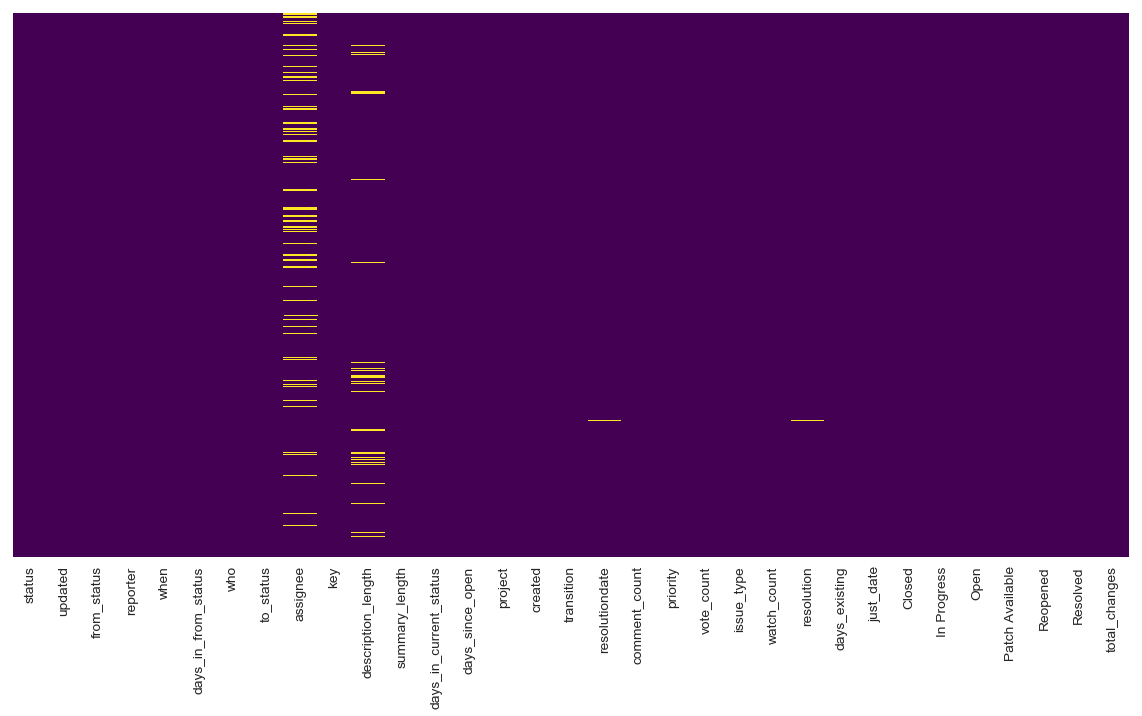

In [392]:
# Check for missing values
plt.figure(figsize=(20,10))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [393]:
# Count missing values
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

assignee              202
description_length     73
resolutiondate          7
resolution              7
dtype: int64

As can be seen from the heatmap and the null_columns there are four columsn which have missing values.

#### assignee 

We will start by imputing the missing values of 'assignee'.

An option would be to impute the 'assignee' with the most frequent value. However, a lot of issues that took a long time to be resolved had the value NaN for assignee. Therefore it seems like the NaN values represent "not assigned".

In [394]:
df.assignee = df.assignee.fillna('not assigned')

#### description length 

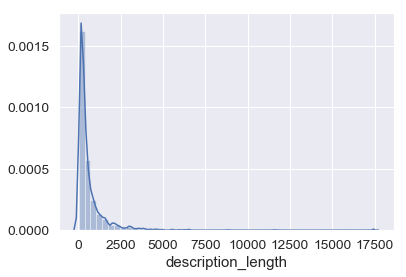

In [395]:
sns.distplot(df[df['description_length'].notnull()]['description_length'])

The missing values in description length need to be filled. As can be seen from the distribution, the description_length is not normal distributed. Therefore it does make no sense to impute with the mean value.

Another option could be to impute based on the summary length. Therefore we will check if there is a correlation between description_length and summary_length. If there is a correlation, we will fill the NaN values of description_length based on the summary_length value.

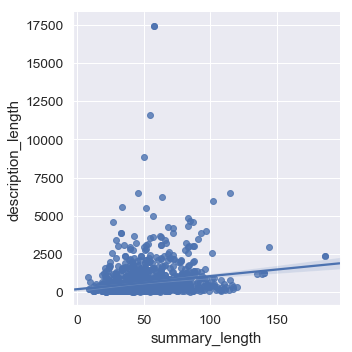

In [396]:
sns.lmplot(x='summary_length',y='description_length',data=df)

In [397]:
df[df['description_length'].notnull()][['description_length','summary_length']].corr()

,description_length,summary_length
description_length,1.000000,0.164776
summary_length,0.164776,1.000000


As can be seen from the correlation matrix, there is almost no correlation between description_length and summary_length. Therefore, we need a different imputation method (e.g. model based imputation).

We could use a KNN model for imputing the missing values of description_length. However, for sake of simplicity of this project, we will use the median for imputing the missing values of description_length.

In [398]:
# Impute missing description_length values with the median
from sklearn.preprocessing import Imputer
imr = Imputer(missing_values='NaN',strategy='median',axis=0)
imr.fit(df['description_length'].values.reshape(-1, 1))
imputed_data = imr.transform(df['description_length'].values.reshape(-1, 1))
df['description_length'] = imputed_data

#### resolution 

The 7 missing values of 'resolution' fill the filled with the most frequent category.

In [399]:
df.resolution = df.resolution.fillna(df['resolution'].value_counts()[0])

#### resolution date 

In [400]:
df[df['resolutiondate'].isna()].head(3)

,status,updated,from_status,reporter,when,days_in_from_status,who,to_status,assignee,key,description_length,summary_length,days_in_current_status,days_since_open,project,created,transition,resolutiondate,comment_count,priority,vote_count,issue_type,watch_count,resolution,days_existing,just_date,Closed,In Progress,Open,Patch Available,Reopened,Resolved,total_changes
7,Reopened,2018-02-22T00:47:38.296+0000,Patch Available,vishelma,2018-02-16T17:38:25.671+0000,2.268346,vishelma,Resolved,vishelma,AVRO-2144,282.0,54,63.720502,3.098008,AVRO,2018-02-13 15:17:17.774,Patch Available to Resolved,NaN,9,Minor,1,Bug,4,1331,0.829662,2018-02-13,1236,0,529,104,5,265,10
65,Patch Available,2017-05-14T23:14:50.647+0000,Open,EliyahuMachluf,2017-03-16T09:39:28.602+0000,0.002080,EliyahuMachluf,Resolved,EliyahuMachluf,AVRO-2008,309.0,71,405.896162,0.002080,AVRO,2017-03-16 09:36:28.894,Open to Resolved,NaN,4,Major,0,Improvement,1,1331,0.000000,2017-03-16,1233,0,475,96,5,196,7
272,Reopened,2016-11-05T22:35:52.631+0000,Open,nielsbasjes,2016-11-05T19:47:20.921+0000,666.438827,rdblue,Resolved,not assigned,AVRO-1626,322.0,46,536.358006,666.438827,AVRO,2015-01-09 09:15:26.266,Open to Resolved,NaN,7,Major,1,Bug,5,1331,0.000000,2015-01-09,1132,0,347,60,3,83,4


The missing values of resolution date will be filled by simply adding 'days_since_open' to 'created'.

In [401]:
temp3= df['days_since_open'].apply(np.ceil).apply(lambda x: pd.Timedelta(x, unit='D'))
df['resolutiondate_2'] = df['created'] + temp3

In [402]:
df['resolutiondate_2'] = str(df['resolutiondate_2'])

In [403]:
df.loc[df['resolutiondate'].isnull(),'resolutiondate'] = df['resolutiondate_2']

In [404]:
# Drop temporary resolutiondate2
df.drop('resolutiondate_2',axis=1,inplace=True)

---------------------------------------------------------------------------------

# 2. Outlier detection & Feature scaling

## 2.1 Log transforming and standardize non-normal distributed features 

In this section we will check for outliers and log-transform distributions with a long tail that are not close to normality. In order to check normality, we will use skewness.

In statistics, skewness is a measure of the asymmetry of the probability distribution of a random variable about its mean. In other words, skewness tells you the amount and direction of skew (departure from horizontal symmetry). The skewness value can be positive or negative, or even undefined. If skewness is 0, the data are perfectly symmetrical, although it is quite unlikely for real-world data. As a general rule of thumb:

•	If skewness is less than -1 or greater than 1, the distribution is highly skewed.

•	If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed.

•	If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.


For skewed features we will first log-transform the values and then apply standardization.

### Target variable: days_in_from_status

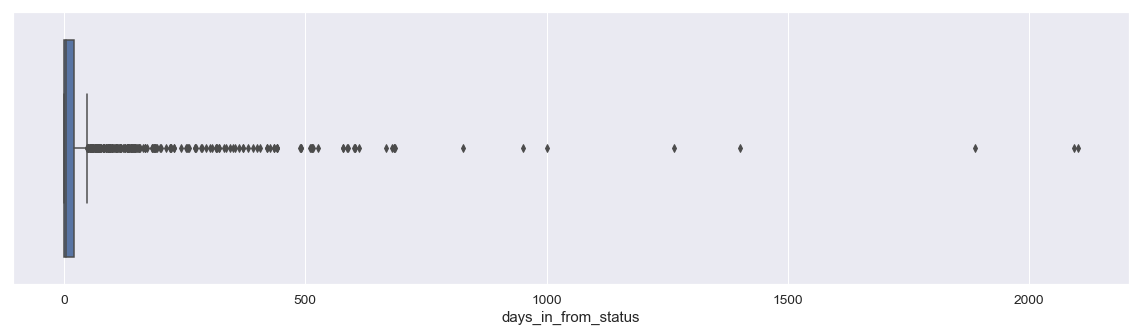

In [405]:
# Outlier detection with boxplot
plt.figure(figsize=(20,5))
sns.boxplot(df['days_in_from_status'])

There seem to be a lot of issues that took longer than 500 days to be resolved. In practice, according to scrum rules, this should not be possible, since an issue should be resolvable within a sprint, with the most common sprint length being 2 weeks. 

First, let's look at the IQR for outlier detection as a starting point.

In [406]:
q1, q3= np.percentile(df.days_in_from_status,[25,75])
iqr = q3 - q1
lower_bound = q1 - (1.5 * q1)
upper_bound = q3 + (1.5 * q3)
print("Lower bound of days_in_from_status: " + str(lower_bound))
print("Upper bound of days_in_from_status: " + str(upper_bound))

Lower bound of days_in_from_status: -0.44540140046300003
Upper bound of days_in_from_status: 49.671855873750005


It is dangerous to remove the outliers, since we cannot be 100% sure that it is a real outlier. However, for sake of simplicity we will remove the issues outise the upper bound of the IQR. 

To validate our reasoning:
It could be the case that an issue will not be resolved in one sprint of 30 days and therefore will be resolved in the next sprint. This goes against scrum rules however. 60 days_in_from_status is close to the upper bound of the IQR. 

In [407]:
# Drop issue where days_since_open is greater than IQR upper bound. 
df = df.drop(df[df.days_since_open > upper_bound].index)

Now we will check the distribution and see if it is normally distributed.

Skewness: 2.167872


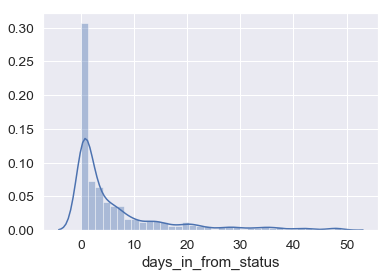

In [408]:
# Plot distribution of target variable: days_in_from_status
sns.distplot(df['days_in_from_status']);
#skewness
print("Skewness: %f" % df['days_in_from_status'].skew())

The target variable has a skewness of over 2.17. Therefore we can conclude it is not normally distributed. We will log-transform the distribution.

In [409]:
df['days_in_from_status_Log'] = np.log1p(df['days_in_from_status'])

Skewness: 0.483781


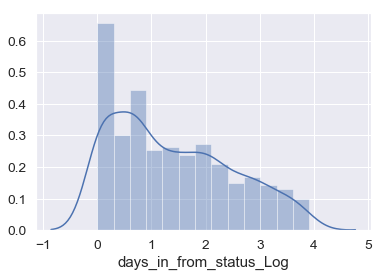

In [410]:
# Plot distribution of target variable: days_in_from_status_Log
sns.distplot(df['days_in_from_status_Log']);
#skewness
print("Skewness: %f" % df['days_in_from_status_Log'].skew())

In [411]:
df.drop('days_in_from_status',axis=1,inplace=True)

#### days_existing

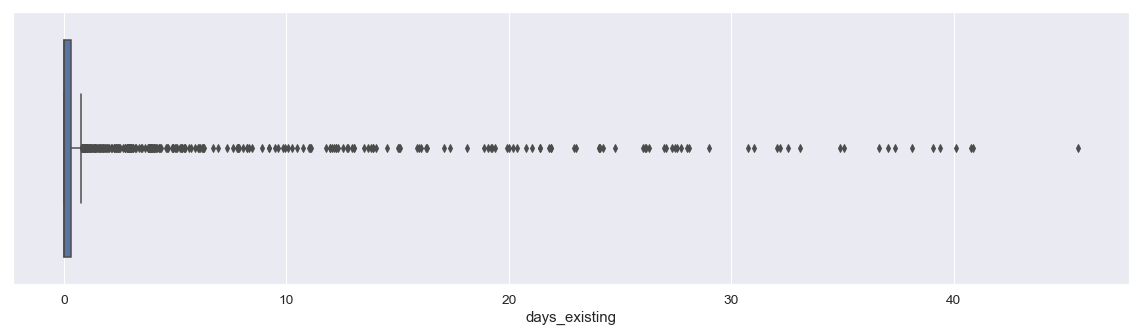

In [412]:
# Outlier detection with boxplot
plt.figure(figsize=(20,5))
sns.boxplot(df['days_existing'])

Skewness: 3.702926


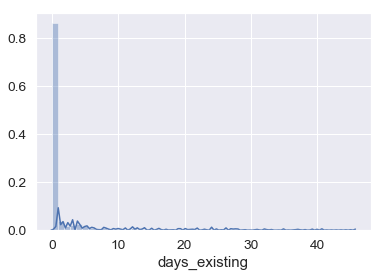

In [413]:
# Plot distribution of days_existing
sns.distplot(df['days_existing']);
#skewness
print("Skewness: %f" % df['days_existing'].skew())

In [414]:
df['days_existing_Log'] = np.log1p(df['days_existing'])

Skewness: 2.021721


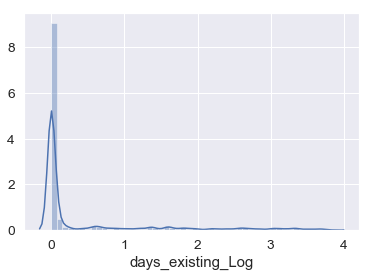

In [415]:
# Plot distribution of days_existing_Log
sns.distplot(df['days_existing_Log']);
#skewness
print("Skewness: %f" % df['days_existing_Log'].skew())

The distribution of days_existing is still not near normal after log-transforming it. Later on we will see that the days_existing_Log is also not a relevant feature, since it has a very low correlation with the target variable.

We will however keep the days_since_creation because we will eventually need it to make the prediction date.

#### description_length 

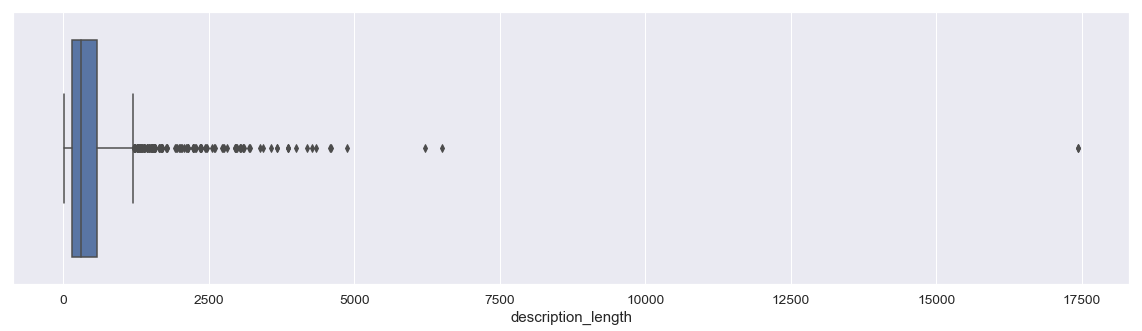

In [416]:
# Outlier detection with boxplot
plt.figure(figsize=(20,5))
sns.boxplot(df['description_length'])

Since we are not sure if the 'outliers' are real outliers (i.e. measurement errors), we will not remove them. In stead, we will log-transform the values of description_length.

Skewness: 9.263707


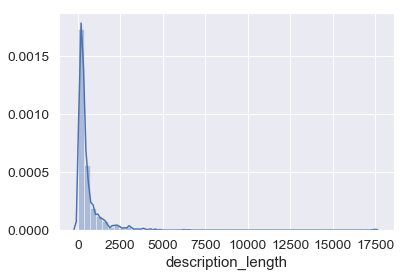

In [417]:
# Plot distribution of description_length
sns.distplot(df['description_length']);
#skewness
print("Skewness: %f" % df['description_length'].skew())

In [418]:
df['description_length_Log'] = np.log(df['description_length'])

After the log transformation, the distribution of the description_length looks as follows.

Skewness: 0.348930


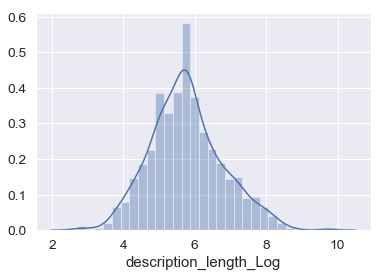

In [419]:
# Plot distribution of description_length_Log
sns.distplot(df['description_length_Log']);
#skewness
print("Skewness: %f" % df['description_length_Log'].skew())

In [420]:
df.drop('description_length',axis=1,inplace=True)

#### summary_length 

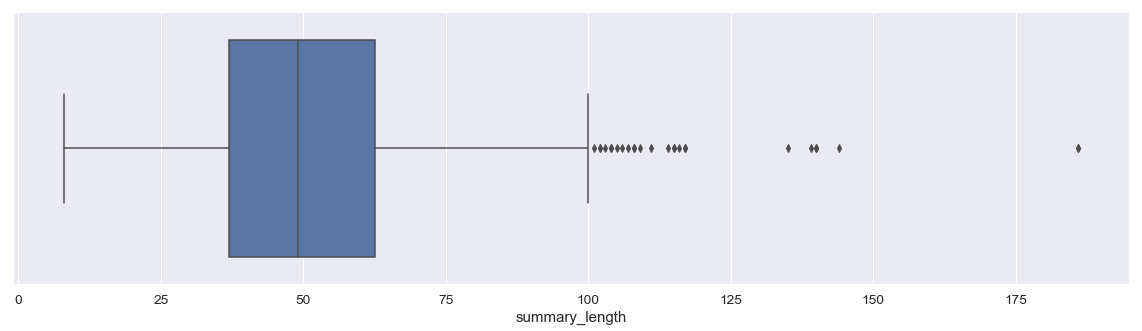

In [421]:
# Outlier detection with boxplot
plt.figure(figsize=(20,5))
sns.boxplot(df['summary_length'])

Although there are some 'outliers' we will handle it with a log-tranformation.

Skewness: 1.260070


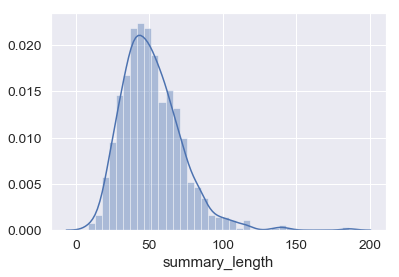

In [422]:
# Plot distribution of the summary_length
sns.distplot(df['summary_length']);
#skewness
print("Skewness: %f" % df['summary_length'].skew())

Now the skewness is little above 1. Therefore we will log-transform the distribution of the summary_length.

In [423]:
df['summary_length_Log'] = np.log1p(df['summary_length'])

Skewness: -0.339465


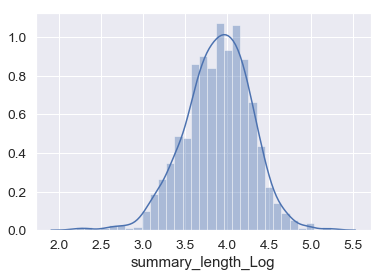

In [424]:
# Plot distribution of the summary_length_Log
sns.distplot(df['summary_length_Log']);
#skewness
print("Skewness: %f" % df['summary_length_Log'].skew())

In [425]:
df.drop('summary_length',axis=1,inplace=True)

#### comment_count

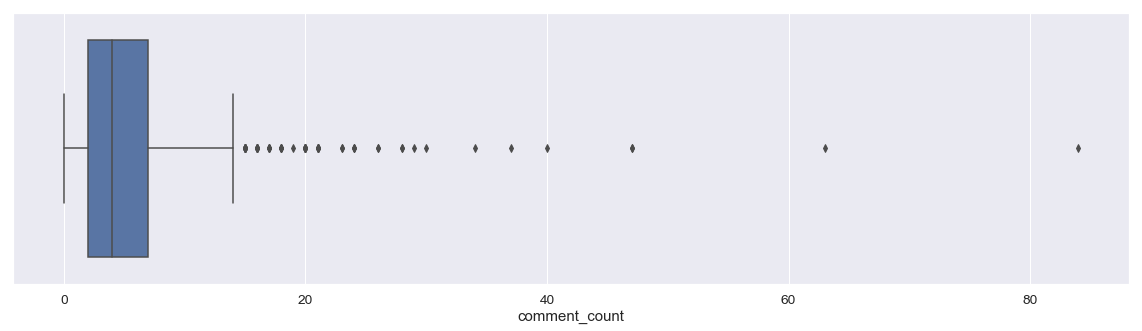

In [426]:
# Outlier detection with boxplot
plt.figure(figsize=(20,5))
sns.boxplot(df['comment_count'])

Skewness: 4.888923


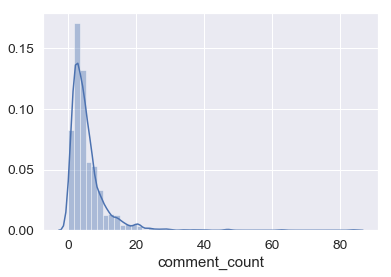

In [427]:
# Plot distribution of comment_count
sns.distplot(df['comment_count']);
#skewness
print("Skewness: %f" % df['comment_count'].skew())

The distribution of comment_count has a long right tail. Therefore we will also log-transform the comment_count.

In [428]:
df['comment_count_Log'] = np.log1p(df['comment_count'])

Skewness: 0.362915


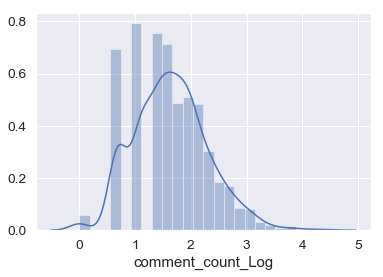

In [429]:
# Plot distribution of comment_count_Log
sns.distplot(df['comment_count_Log']);
#skewness
print("Skewness: %f" % df['comment_count_Log'].skew())

In [430]:
df.drop('comment_count',axis=1,inplace=True)

#### watch_count 

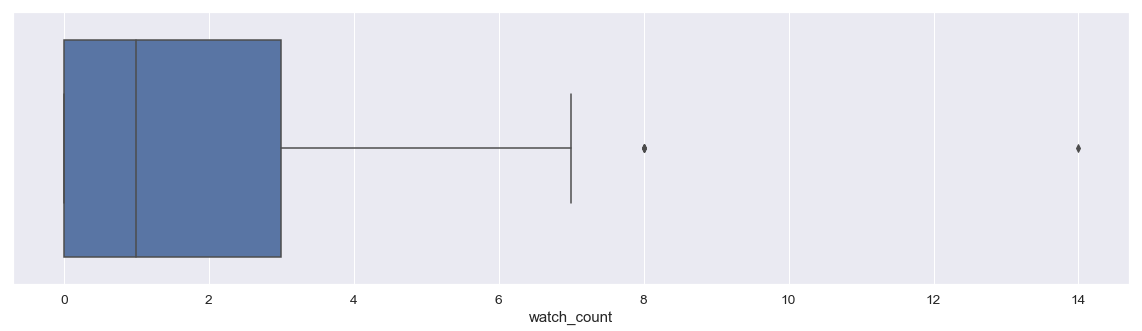

In [431]:
# Outlier detection with boxplot
plt.figure(figsize=(20,5))
sns.boxplot(df['watch_count'])

Skewness: 1.266815


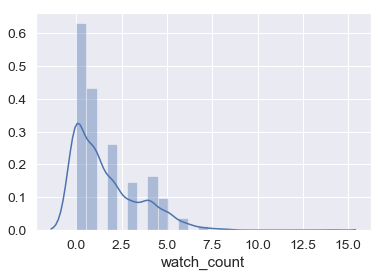

In [432]:
# Plot distribution of watch_count
sns.distplot(df['watch_count']);
#skewness
print("Skewness: %f" % df['watch_count'].skew())

In [433]:
df['watch_count_Log'] = np.log1p(df['watch_count'])

Skewness: 0.233507


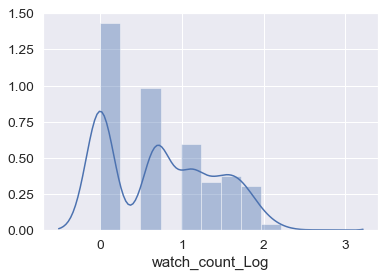

In [434]:
# Plot distribution of watch_count_Log
sns.distplot(df['watch_count_Log']);
#skewness
print("Skewness: %f" % df['watch_count_Log'].skew())

In [435]:
df.drop('watch_count',axis=1,inplace=True)

#### vote_count 

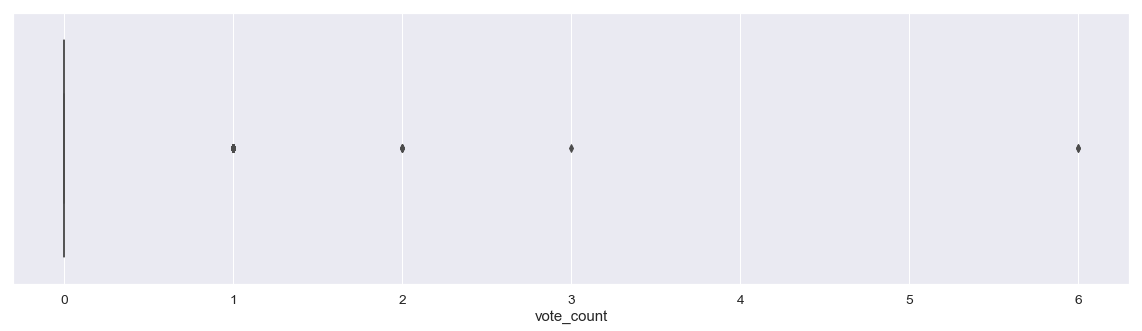

In [436]:
# Outlier detection with boxplot
plt.figure(figsize=(20,5))
sns.boxplot(df['vote_count'])

Most issues seem to have zero vote_counts but could go up to 6. Therefore we cannot treat these as real outliers.

Skewness: 11.100516


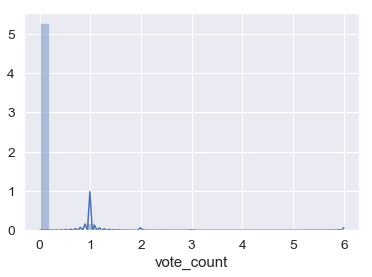

In [437]:
# Plot distribution of vote_count
sns.distplot(df['vote_count']);
#skewness
print("Skewness: %f" % df['vote_count'].skew())

In [438]:
df['vote_count_Log'] = np.log1p(df['vote_count'])

Skewness: 5.990118


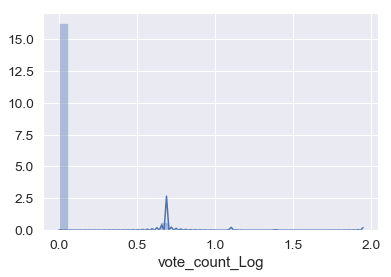

In [439]:
# Plot distribution of vote_count_Log
sns.distplot(df['vote_count_Log']);
#skewness
print("Skewness: %f" % df['vote_count_Log'].skew())

As can be seen from the log transformation, the vote_counts are still not near a normal distribution. 

We will solve this by binning the feature vote_counts, where we will create a new variable: 'vote', which has either the value 'yes' or 'no'.

##### Binning vote_counts 

In [440]:
# Create a list to store the data
vote = []

# For each row in the column,
for row in df['vote_count']:
    # if more than zero,
    if row > 0:
        # Append 
        vote.append('yes')
    else:
        # Append a no
        vote.append('no')
        
# Create a column from the list
df['vote'] = vote

In [441]:
# Drop vote_count and vote_count_Log
df.drop(['vote_count','vote_count_Log'],axis=1,inplace=True)

----------------------------------------------------------------

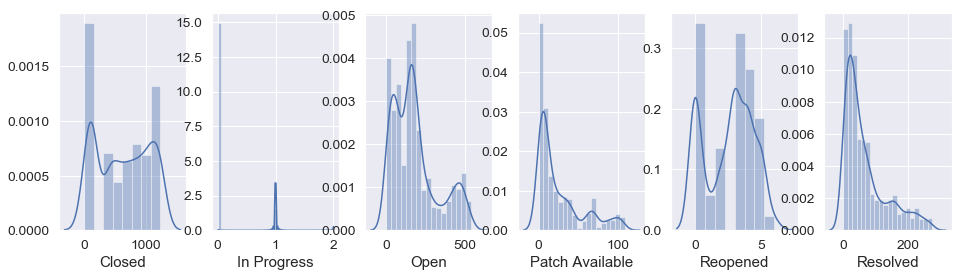

In [442]:
# Plot distribution of the statusses on a certain datetime
fig, ax =plt.subplots(1,6, figsize=(16,4))
sns.distplot(df['Closed'], ax=ax[0])
sns.distplot(df['In Progress'], ax=ax[1])
sns.distplot(df['Open'], ax=ax[2])
sns.distplot(df['Patch Available'], ax=ax[3])
sns.distplot(df['Reopened'], ax=ax[4])
sns.distplot(df['Resolved'], ax=ax[5])
fig.show()

The amount of Closed and Resolved issues are not relevant, since these have to impact on issues that need to be resolved. 

Therefore we will take into account In Progress, Open, Patch Available and Reopened.

In [443]:
df.drop(['Closed','Resolved'],axis=1,inplace=True)

#### total_changes 

Skewness: 1.677384


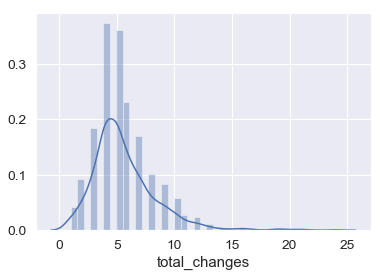

In [444]:
# Plot distribution of total_changes
sns.distplot(df['total_changes']);
#skewness
print("Skewness: %f" % df['total_changes'].skew())

In [445]:
df['total_changes_Log'] = np.log1p(df['total_changes'])

Skewness: -0.114486


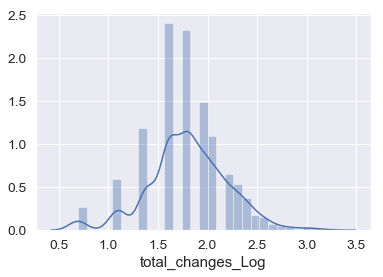

In [446]:
# Plot distribution of total_changes_Log
sns.distplot(df['total_changes_Log']);
#skewness
print("Skewness: %f" % df['total_changes_Log'].skew())

In [447]:
df.drop('total_changes',axis=1,inplace=True)

#### Open 

Skewness: 0.908629


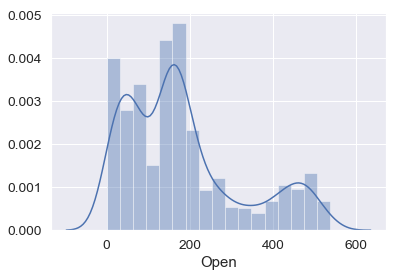

In [448]:
# Plot distribution of Open
sns.distplot(df['Open']);
#skewness
print("Skewness: %f" % df['Open'].skew())

We can leave the distribution of Open as it is.

#### Patch Available 

Skewness: 1.338560


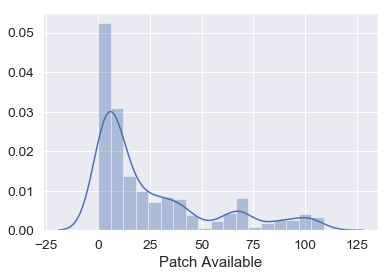

In [449]:
# Plot distribution of Patch Available
sns.distplot(df['Patch Available']);
#skewness
print("Skewness: %f" % df['Patch Available'].skew())

In [450]:
df['Patch Available_Log'] = np.log1p(df['Patch Available'])

Skewness: -0.101790


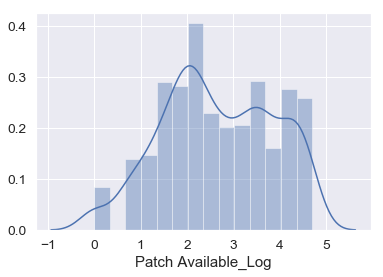

In [451]:
# Plot distribution of Patch Available_Log
sns.distplot(df['Patch Available_Log']);
#skewness
print("Skewness: %f" % df['Patch Available_Log'].skew())

In [452]:
df.drop('Patch Available',axis=1,inplace=True)

#### Reopened 

Skewness: -0.208957


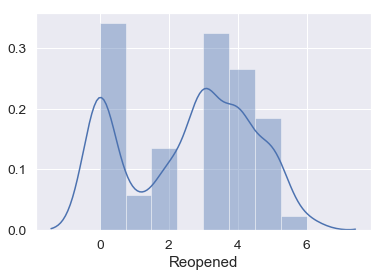

In [453]:
# Plot distribution of Reopened
sns.distplot(df['Reopened']);
#skewness
print("Skewness: %f" % df['Reopened'].skew())

We can leave the distribution of Reopened as it is.

##### Binning 'In Progress' values 

Since 'In Progress' has a lot of zero values (i.e. there is on that date no other issue in progress), we will create a new feature where in progress is either 'yes' or 'no'.

In [454]:
# Create a list to store the data
in_progress = []

# For each row in the column,
for row in df['In Progress']:
    # if more than zero,
    if row > 0:
        # Append 
        in_progress.append('yes')
    else:
        # Append a failing grade
        in_progress.append('no')
        
# Create a column from the list
df['in_progress'] = in_progress

In [455]:
df.drop('In Progress',axis=1, inplace=True)

# 3. Feature selection

In this section we will explore which features are either redundant or irrelevant, and can thus be removed without incurring much loss of information.

First we will remove irrelevant features:
- status
- updated
- when
- created
- to_status (since we filtered our new dataframe to 'Resolved' only)
- days_in_current_status
- days_since_open
- project
- transition (redundant information)
- resolution (this information will not be available upfront, therefore we cannot use it as an input variable)

In [456]:
df.columns

Index(['status', 'updated', 'from_status', 'reporter', 'when', 'who', 'to_status', 'assignee', 'key', 'days_in_current_status', 'days_since_open', 'project', 'created', 'transition', 'resolutiondate', 'priority', 'issue_type', 'resolution', 'days_existing', 'just_date', 'Open', 'Reopened', 'days_in_from_status_Log', 'days_existing_Log', 'description_length_Log', 'summary_length_Log', 'comment_count_Log', 'watch_count_Log', 'vote', 'total_changes_Log', 'Patch Available_Log', 'in_progress'], dtype='object')

In [457]:
columns = ['status', 'updated', 'when','created','to_status','days_in_current_status','days_since_open','project','transition','resolution']
df.drop(columns, inplace=True, axis=1)

## 3.1 Numerical feature selection 

In [458]:
numerical_feats = df.dtypes[df.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

Number of Numerical features:  11


In [459]:
numerical_feats

Index(['days_existing', 'Open', 'Reopened', 'days_in_from_status_Log', 'days_existing_Log', 'description_length_Log', 'summary_length_Log', 'comment_count_Log', 'watch_count_Log', 'total_changes_Log', 'Patch Available_Log'], dtype='object')

In [239]:
# Get feature importance with Random Forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

In [240]:
X_fi = df[['days_existing', 'Open', 'Reopened', 'days_existing_Log', 'description_length_Log', 'summary_length_Log', 'comment_count_Log', 'watch_count_Log', 'total_changes_Log', 'Patch Available_Log']]

In [241]:
y_fi = df['days_in_from_status_Log']

In [242]:
rf.fit(X_fi,y_fi)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

 1) description_length_Log         0.176831
 2) comment_count_Log              0.165893
 3) summary_length_Log             0.144192
 4) Open                           0.129767
 5) Patch Available_Log            0.087504
 6) total_changes_Log              0.077371
 7) watch_count_Log                0.076162
 8) days_existing_Log              0.055990
 9) days_existing                  0.051300
10) Reopened                       0.034991


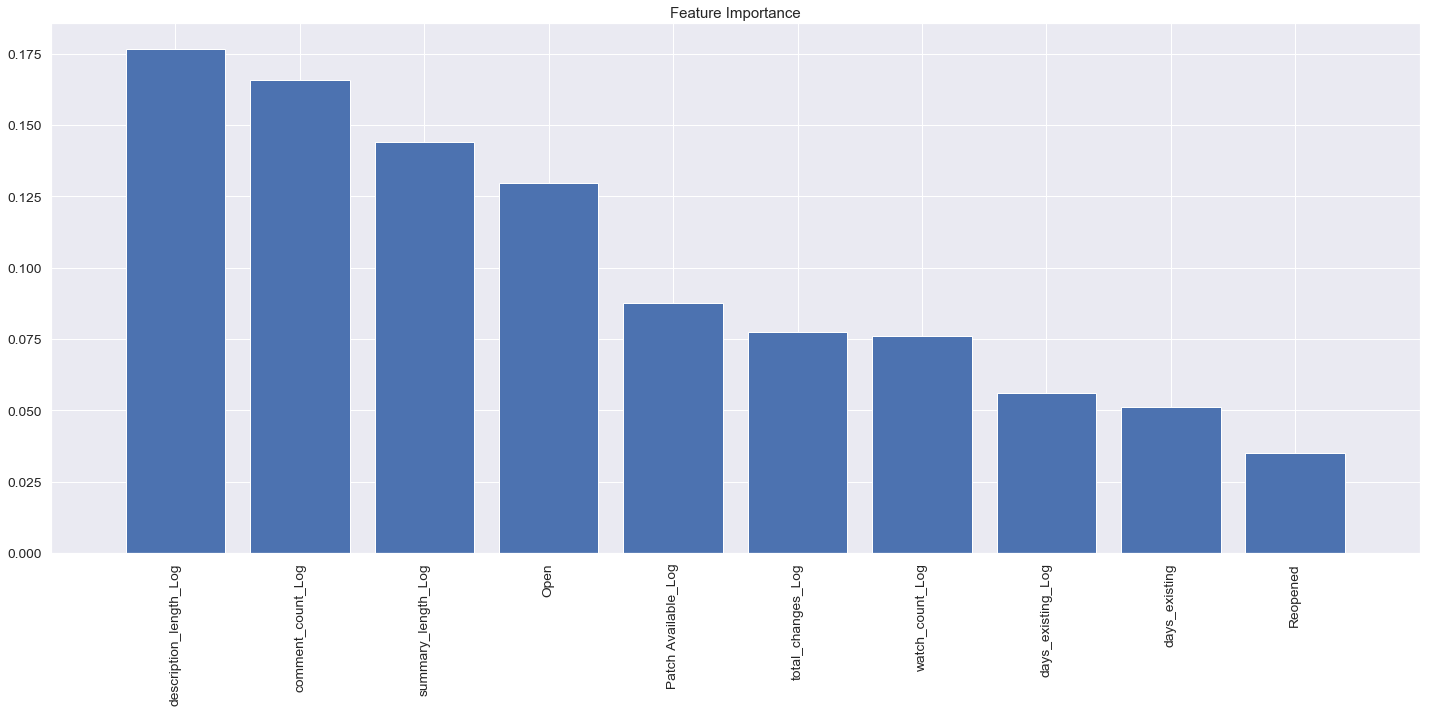

In [243]:
# Feature importance
feat_labels = X_fi.columns

importances = rf.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_fi.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.figure(figsize=(20,10))
plt.title('Feature Importance')
plt.bar(range(X_fi.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_fi.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_fi.shape[1]])
plt.tight_layout()
plt.show()

From the feature importance of the random forest, we can see that the description length is the most important, followed by comment count, summary_length and amount of Open issues at date of creation. 

Based on both the feature importance of the random forest, we will only take into account the following features: 
- description length
- comment count
- summary length
- Open

In [246]:
numerical_feats

Index(['days_existing', 'Open', 'Reopened', 'days_in_from_status_Log', 'days_existing_Log', 'description_length_Log', 'summary_length_Log', 'comment_count_Log', 'watch_count_Log', 'total_changes_Log', 'Patch Available_Log'], dtype='object')

In [247]:
# Numerical features to drop
df.drop(['Reopened', 'days_existing_Log','watch_count_Log', 'total_changes_Log', 'Patch Available_Log'], inplace=True, axis=1)

In [248]:
num_features = df[['description_length_Log','comment_count_Log','summary_length_Log','Open']]

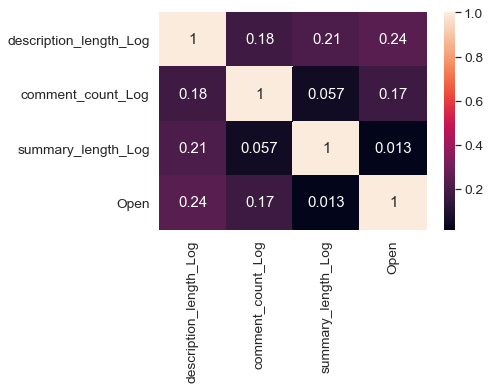

In [249]:
# Check for multicollinearity
# calculate the correlation matrix
corr = num_features.corr()
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,annot=True)

There seems no real multicollinearity between independent numerical features if we judge multicollinearity as a correlation higher than 0.7. Therefore, we will not exclude additional features.

Source: Dormann, C. F., J. Elith, S. Bacher, et al. 2013. Collinearity: a review of methods to deal with it and a simulation study evaluating their performance. Ecography 36:27–46.

## 3.2 Cluster low frequent caterogical feature values

In [250]:
# Create top 5 list of reporters
reporter_list = df['reporter'].value_counts()[:5].keys().tolist()

In [251]:
def reporter_other(x):
    if x['reporter'] in reporter_list:
        return x['reporter']
    else:
        return 'Other'

In [252]:
# apply function to replace values with 'Other'
df['reporter'] = df.apply(reporter_other, axis=1)

In [253]:
# Create top 5 list of who did the transition
who_list = df['who'].value_counts()[:5].keys().tolist()

In [254]:
def who_other(x):
    if x['who'] in who_list:
        return x['who']
    else:
        return 'Other'

In [255]:
# apply function to replace values with 'Other'
df['who'] = df.apply(who_other, axis=1)

In [256]:
# Create top 5 list of the assignees
assignee_list = df['assignee'].value_counts()[:5].keys().tolist()

In [257]:
def assignee_other(x):
    if x['assignee'] in assignee_list:
        return x['assignee']
    else:
        return 'Other'

In [258]:
# apply function to replace values with 'Other'
df['assignee'] = df.apply(assignee_other, axis=1)

-----------------------------------------------------------------------

## 3.3 Feature extraction 

We will extract information from the 'just_date' column, such as the month or the day of the week.

In [259]:
df['just_date'] = pd.to_datetime(df['just_date'])

In [260]:
df['month'] = df['just_date'].dt.month
df['day'] = df['just_date'].dt.weekday

To see if the day of the week of the week and the month when the issue was created has an impact on the days_in_from_status_Log, we will make a visualization.

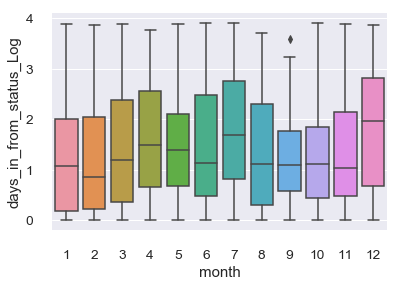

In [261]:
# Boxplot of the month and days_in_from_status_Log
sns.boxplot(x="month", y="days_in_from_status_Log",
            data=df)
sns.despine(offset=10, trim=True)

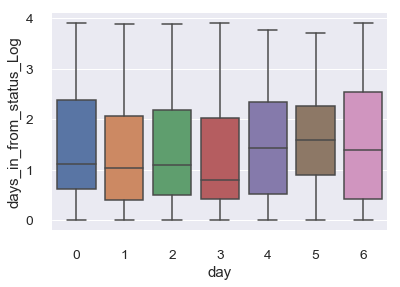

In [262]:
# Boxplot of the day of the week and days_in_from_status_Log
sns.boxplot(x="day", y="days_in_from_status_Log",
            data=df)
sns.despine(offset=10, trim=True)

We will first map the weekday to day names.

In [263]:
day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday',3: 'Thursday',4: 'Friday',5: 'Saterday',6: 'Sunday'}
df['day'] = df['day'].map(day_mapping)

##### Binning months 

We will group the months into seasons to reduce the amount of dimensions of our model.

In [264]:
# Group months into seasons.
# First create an empty list
season = []

# For each row in the column,
for row in df['month']:
    if row in range(3,6):
        season.append('spring')

    elif row in range(6,9):
        season.append('summer')
        
    elif row in range(9,12):
        season.append('fall')    
# otherwise,
    else:
        season.append('winter')
        
# Create a column from the list
df['season'] = season

In [265]:
df.drop('month',axis=1,inplace=True)

## 3.4 Encoding categorical features: creating dummies 

Before we create dummies for categorical features, we first need to see if the features will have an influence on the days_since_open.

In [266]:
categorical_feats = df.dtypes[df.dtypes == "object"].index

In [267]:
categorical_feats

Index(['from_status', 'reporter', 'who', 'assignee', 'key', 'resolutiondate', 'priority', 'issue_type', 'vote', 'in_progress', 'day', 'season'], dtype='object')

In [268]:
cat_features = ['from_status', 'reporter', 'who', 'assignee', 'priority', 'issue_type', 'vote','in_progress','day','season']

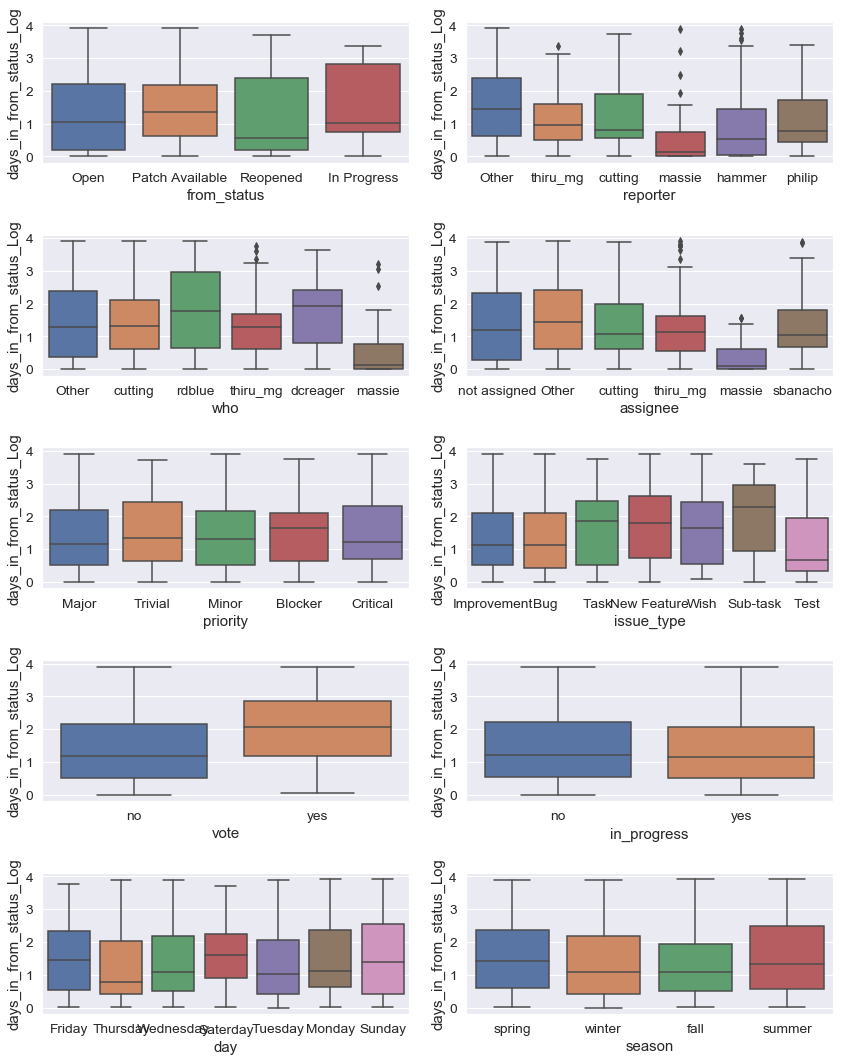

In [269]:
nr_rows = 5
nr_cols = 2

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*6,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(cat_features):
            sns.boxplot(x=cat_features[i], y=df['days_in_from_status_Log'], data=df, ax = axs[r][c],)
              
plt.tight_layout()
plt.show()

It looks like all categorical features but in_progress have an influence on the days_since_open_Log values. Therefore we will drop in_progress first.

In [270]:
df.drop('in_progress',axis=1, inplace=True)

In [271]:
# Get dummies
df_dummies = pd.get_dummies(df[['from_status', 'reporter', 'who', 'assignee', 'issue_type','vote','day','season','priority']],drop_first = True)

In [272]:
# Merge with old dataframe
df = pd.merge(df_dummies, df, left_index=True, right_index=True)

In [273]:
# Drop non-dummy columns
columns_todrop = ['from_status', 'reporter', 'who', 'assignee', 'issue_type', 'vote','day','season','priority']
df.drop(columns_todrop, inplace=True, axis=1)

# 4. Feature scaling: standardization

After the log-transformation we will apply another feature scaling to all numerical features: standardization with the StandardScaler to bring all features on the same scale.

The standardization will be applied to the following numerical features:

- comment_count_Log
- summary_length_Log
- description_length_Log
- Open

### Standardizing numerical features 

Now we can standardize the numerical features.

In [275]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [277]:
scaled_features = scaler.fit_transform(df[['comment_count_Log', 'summary_length_Log','Open', 'description_length_Log']])
scaled_df = pd.DataFrame(scaled_features, columns=['comment_count_Log', 'summary_length_Log','Open', 'description_length_Log'])

In [278]:
# Merge scaled_df with normal df on index
df_scaled = pd.merge(scaled_df, df, left_index=True, right_index=True)

### Drop remaining features

In [281]:
df_scaled.drop(['comment_count_Log_y', 'description_length_Log_y','Open_y', 'Open_y','summary_length_Log_y'],axis=1,inplace=True)

## Export to CSV 

In [282]:
# export clean dataframe to CSV
df_scaled.to_csv('clean_data_issues3.csv',encoding='utf-8', index=False)

## 5. Split train-test data

In [462]:
# Read clean CSV data
df = pd.read_csv('clean_data_issues3.csv')

In [463]:
df.head(1)

,comment_count_Log_x,summary_length_Log_x,Open_x,description_length_Log_x,from_status_Open,from_status_Patch Available,from_status_Reopened,reporter_cutting,reporter_hammer,reporter_massie,reporter_philip,reporter_thiru_mg,who_cutting,who_dcreager,who_massie,who_rdblue,who_thiru_mg,assignee_cutting,assignee_massie,assignee_not assigned,assignee_sbanacho,assignee_thiru_mg,issue_type_Improvement,issue_type_New Feature,issue_type_Sub-task,issue_type_Task,issue_type_Test,issue_type_Wish,vote_yes,day_Monday,day_Saterday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,season_spring,season_summer,season_winter,priority_Critical,priority_Major,priority_Minor,priority_Trivial,key,resolutiondate,days_existing,just_date,days_in_from_status_Log
0,-2.507038,1.13315,2.51949,1.178348,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,AVRO-2169,2018-04-24T06:34:58.762+0000,0.0,2018-04-06,2.928579


In [284]:
X = df.drop(['days_in_from_status_Log','just_date','resolutiondate','key','days_existing'], axis=1)
y = df['days_in_from_status_Log']

In [285]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

# Learning and evaluation

In [286]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

### Select a performance measure: Root Mean Square Error

To measure how a model perform on the test data, we will use a typical performance measure for regression problems: Root Mean Square Error (RMSE). The reason why we will use the RMSE is because RMSE gives a relatively high weight to large errors. In our case the sensitivity to large model errors is important, since predicting that an issue will take 20 days in stead of 40, weighs heavier than predicting that an issue will take 10 days in stead of 20.

--------------------------------------

## Nested cross-validation for tuned model comparison

First we will compare different algorithms after tune their hyperparamters by performing a nested cross-validation. 

## 1. Linear regression 

In [287]:
from sklearn.linear_model import LinearRegression

In [288]:
lr = LinearRegression()

In [289]:
lr_scores = cross_val_score(estimator=lr,X=X_train,y=y_train,cv=10,n_jobs=1,scoring='neg_mean_squared_error')

In [290]:
lr_scores

array([-1.32300703, -0.85667424, -0.99311523, -1.02013893, -1.22653304,
       -1.11837687, -0.80649229, -1.10772809, -1.20368831, -1.19104787])

In [291]:
print('CV performance of Linear Regression: %.3f +/- %.3f' % (np.mean(lr_scores), 
                                      np.std(lr_scores)))

CV performance of Linear Regression: -1.085 +/- 0.157


## 2. Polynomial regression

In [292]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

### Fine-tune with nested grid search cross validation (10x10)

In [293]:
param_grid = {'polynomialfeatures__degree': np.arange(3), 'linearregression__fit_intercept': [True, False], 'linearregression__normalize': [True, False]}

In [294]:
poly_grid = GridSearchCV(PolynomialRegression(), param_grid, 
                         cv=10, 
                         scoring='neg_mean_squared_error', 
                         verbose=1) 

In [295]:
scores_poly = cross_val_score(poly_grid,X_train,y_train, scoring = 'neg_mean_squared_error', cv=10)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    6.4s finished


Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    7.1s finished


Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    7.2s finished


Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    7.1s finished


Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    6.5s finished


Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    6.5s finished


Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    6.6s finished


Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    6.4s finished


Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    6.1s finished


Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    6.7s finished


In [296]:
scores_poly

array([-1.32300703, -0.85667424, -0.99311523, -1.02013893, -1.22653304,
       -1.11837687, -0.80649229, -1.10772809, -1.20368831, -1.19104787])

In [297]:
print('CV performance of Polynomial Regression: %.3f +/- %.3f' % (np.mean(scores_poly), 
                                      np.std(scores_poly)))

CV performance of Polynomial Regression: -1.085 +/- 0.157


## 3. Ridge regression 

In [298]:
from sklearn.linear_model import Ridge

### Fine-tune with nested grid search cross validation (10x10)

In [299]:
ridge = Ridge()
parameters_ridge = {'alpha':[0.001,0.005,0.01,0.1,0.5,1], 'normalize':[True,False], 'tol':[1e-06,5e-06,1e-05,5e-05]}
grid_ridge = GridSearchCV(ridge, parameters_ridge, cv=10, verbose=1, scoring = 'neg_mean_squared_error')

In [300]:
scores_ridge = cross_val_score(grid_ridge,X_train,y_train, scoring = 'neg_mean_squared_error', cv=10)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:    2.3s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:    2.7s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:    2.4s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:    2.4s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:    2.4s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:    2.5s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:    2.6s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:    2.7s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:    2.6s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:    2.7s finished


In [301]:
scores_ridge

array([-1.13575236, -0.86029575, -0.95162414, -0.98923129, -1.13738307,
       -1.17090297, -0.8182199 , -1.09232907, -1.20634056, -1.16103224])

In [302]:
print('CV performance of Ridge Regression: %.3f +/- %.3f' % (np.mean(scores_ridge), 
                                      np.std(scores_ridge)))

CV performance of Ridge Regression: -1.052 +/- 0.131


## 4. Lasso regression 

In [303]:
from sklearn.linear_model import Lasso

### Fine-tune with nested grid search cross validation (10x10)

In [304]:
lasso = Lasso()
parameters_lasso = {'alpha':[0.001,0.005,0.01,0.1,0.5,1], 'normalize':[True,False], 'tol':[1e-06,5e-06,1e-05,5e-05]}
grid_lasso = GridSearchCV(lasso, parameters_lasso, cv=10, verbose=1, scoring = 'neg_mean_squared_error')

In [305]:
scores_lasso = cross_val_score(grid_lasso,X_train,y_train, scoring = 'neg_mean_squared_error', cv=10)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:    1.3s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:    1.2s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:    1.1s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:    1.3s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:    1.3s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:    1.1s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:    1.2s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:    1.1s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:    1.0s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:    1.1s finished


In [306]:
scores_lasso

array([-1.1634481 , -0.84633282, -0.94229921, -0.94155868, -1.14494401,
       -1.11251593, -0.78453036, -1.08329475, -1.18657854, -1.28383949])

In [307]:
print('CV performance of Lasso Regression: %.3f +/- %.3f' % (np.mean(scores_lasso), 
                                      np.std(scores_lasso)))

CV performance of Lasso Regression: -1.049 +/- 0.153


## 5. Decision Tree 

In [308]:
from sklearn.tree import DecisionTreeRegressor

In [309]:
dtr = DecisionTreeRegressor()

In [310]:
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
grid_dtr = {'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print(grid_dtr)

{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


### Fine-tune with nested grid search cross validation (10x10)

In [311]:
grid_dtr = GridSearchCV(dtr, grid_dtr, cv=10, verbose=1, scoring = 'neg_mean_squared_error')

In [312]:
scores_dtr = cross_val_score(grid_dtr,X_train,y_train, scoring = 'neg_mean_squared_error', cv=10)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:    4.1s finished


Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:    3.9s finished


Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:    4.0s finished


Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:    4.0s finished


Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:    4.0s finished


Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:    3.9s finished


Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:    4.0s finished


Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:    4.0s finished


Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:    3.9s finished


Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:    3.9s finished


In [322]:
scores_dtr

array([-1.49965632, -1.59310684, -1.32936893, -1.57851298, -1.59983368,
       -1.65891659, -1.45034492, -1.49726312, -1.50268168, -1.59516818])

In [323]:
print('CV performance of Decision Tree regressor: %.3f +/- %.3f' % (np.mean(scores_dtr), 
                                      np.std(scores_dtr)))

CV performance of Decision Tree regressor: -1.530 +/- 0.090


## 6. Random Forest

In [315]:
from sklearn.ensemble import RandomForestRegressor

In [316]:
rf = RandomForestRegressor()

### Fine-tune with nested randomized search cross validation (10x3)

Since we use much larger grid for all the possible hyperparameter values, we will use a randomized search CV, which draws random hyperparameter combintaions.

In [317]:
# Random Hyperparameter Grid
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [318]:
# Randomized search CV for Random Forest
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [319]:
# Get cross validation score of optimized model
scores_rf = cross_val_score(rf_random,X_train,y_train,scoring='neg_mean_squared_error',cv=10)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.0min finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   60.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.1min finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.1min finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.0min finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.0min finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.0min finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.2min finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.5min finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.2min finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.1min finished


In [324]:
scores_rf

array([-1.11926418, -0.89901202, -0.89153626, -0.98600084, -1.14197714,
       -1.08783805, -0.90398633, -1.14729631, -1.0848363 , -1.18661735])

In [325]:
print('CV performance of Random Forest: %.3f +/- %.3f' % (np.mean(scores_rf), 
                                      np.std(scores_rf)))

CV performance of Random Forest: -1.045 +/- 0.108


## 7. Support Vector Machine  

In [326]:
from sklearn.svm import SVR

In [327]:
svr = SVR()

### Fine-tune with nested grid search cross validation (10x10)

In [328]:
params_grid_svr = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.0001, 0.001, 0.01, 0.1],
               'kernel':['linear','rbf', 'poly'] }

In [329]:
grid_svm = GridSearchCV(svr, params_grid_svr, cv=10, verbose=1, scoring = 'neg_mean_squared_error')

In [330]:
scores_svm = cross_val_score(grid_svm,X_train,y_train, scoring = 'neg_mean_squared_error', cv=10)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:  1.2min finished


Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:  1.1min finished


Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:  1.2min finished


Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:  1.2min finished


Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:  1.2min finished


Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:  1.2min finished


Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:  1.2min finished


Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:  1.1min finished


Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:  1.2min finished


Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:  1.1min finished


In [331]:
scores_svm

array([-1.16983912, -0.93295572, -1.0106226 , -0.98716657, -1.13009073,
       -1.20619143, -1.04175811, -1.19052098, -1.36074865, -1.27862999])

In [332]:
print('CV performance of Support Vector Machine: %.3f +/- %.3f' % (np.mean(scores_svm), 
                                      np.std(scores_svm)))

CV performance of Support Vector Machine: -1.131 +/- 0.129


# Compare different ML models

Based on the nested cross validation we will compare the different models to see which model performs best.

In order to see the real root mean square errors, we will convert the mean square error back to normal.

In [333]:
from math import *

In [334]:
lr_scores_coverted = np.sqrt(np.expm1(-1*lr_scores))
poly_scores_coverted = np.sqrt(np.expm1(-1*scores_poly))
ridge_scores_coverted = np.sqrt(np.expm1(-1*scores_ridge))
lasso_scores_coverted = np.sqrt(np.expm1(-1*scores_lasso))
dtr_scores_coverted = np.sqrt(np.expm1(-1*scores_dtr))
rf_scores_coverted = np.sqrt(np.expm1(-1*scores_rf))
svm_scores_coverted = np.sqrt(np.expm1(-1*scores_svm))

Linear Regression: 1.402 +/- 0.165
Polynomial Regression: 1.402 +/- 0.165
Ridge Regression: 1.367 +/- 0.136
Lasso Regression: 1.365 +/- 0.161
Decision Tree: 1.904 +/- 0.108
Random Forest: 1.359 +/- 0.113
Support Vector Machine: 1.451 +/- 0.139


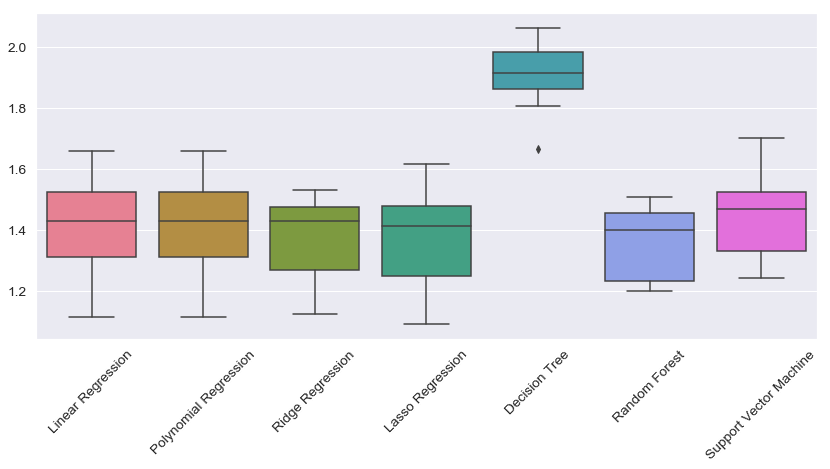

In [335]:
# Comparison of MSE of the models
CVscores = [lr_scores_coverted,poly_scores_coverted,ridge_scores_coverted,lasso_scores_coverted,dtr_scores_coverted,rf_scores_coverted,svm_scores_coverted]
models = ['Linear Regression','Polynomial Regression','Ridge Regression','Lasso Regression','Decision Tree','Random Forest','Support Vector Machine']
plt.figure(figsize=(14,6))
plt.xticks(rotation=45)
sns.boxplot(models,CVscores,palette='husl')

print('Linear Regression: %.3f +/- %.3f' % (np.mean(lr_scores_coverted), np.std(lr_scores_coverted)))
print('Polynomial Regression: %.3f +/- %.3f' % (np.mean(poly_scores_coverted), np.std(poly_scores_coverted)))
print('Ridge Regression: %.3f +/- %.3f' % (np.mean(ridge_scores_coverted), np.std(ridge_scores_coverted)))
print('Lasso Regression: %.3f +/- %.3f' % (np.mean(lasso_scores_coverted), np.std(lasso_scores_coverted)))
print('Decision Tree: %.3f +/- %.3f' % (np.mean(dtr_scores_coverted), np.std(dtr_scores_coverted)))
print('Random Forest: %.3f +/- %.3f' % (np.mean(rf_scores_coverted), np.std(rf_scores_coverted)))
print('Support Vector Machine: %.3f +/- %.3f' % (np.mean(svm_scores_coverted), np.std(svm_scores_coverted)))

As can be seen from the boxplot, the hyper-tuned models of Random Forest Regressor performs best, although almost all models perform equally.

# Retrain hyper-tuned Random Forest Regressor

In [352]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [466]:
rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.1min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=2)

In [467]:
print(rf_random.best_params_)

{'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}


In [339]:
final_regressor = rf_random.best_estimator_

In [340]:
# Retrain optimized Random Forest on training set
final_regressor.fit(X_train,y_train)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=80,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [341]:
final_regressor_pred = final_regressor.predict(X_test)

In [342]:
RMSE = sqrt(mean_squared_error(y_test, final_regressor_pred))

In [343]:
print("RMSE of final model :" + str(RMSE))

RMSE of final model :1.0634906229407874


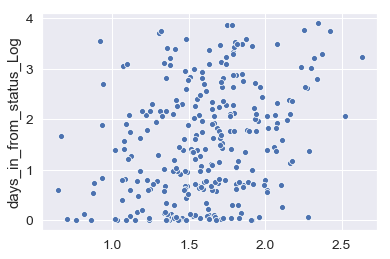

In [344]:
sns.scatterplot(final_regressor_pred,y_test)

In [345]:
# Convert to real predictions
real_predictions = np.expm1(final_regressor_pred)

In [346]:
real_y_test = np.expm1(y_test)

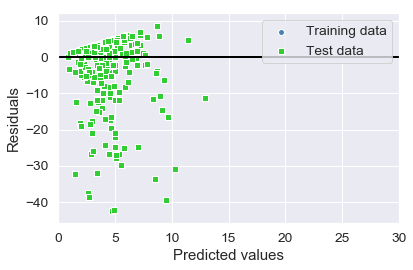

In [348]:
plt.scatter(real_predictions,  real_predictions - real_y_test,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
plt.scatter(real_predictions,  real_predictions - real_y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper right')
plt.hlines(y=0, xmin=0, xmax=30, color='black', lw=2)
plt.xlim([0, 30])
plt.tight_layout()
plt.show()

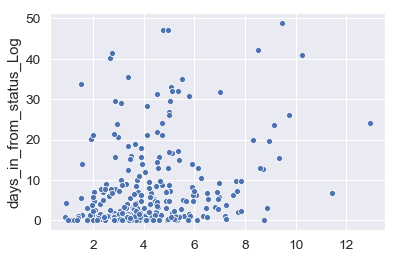

In [349]:
sns.scatterplot(real_predictions,real_y_test)

In [353]:
# Real MAE
mean_absolute_error(real_y_test,real_predictions)

6.278683215807497

In [468]:
# Real RMSE
sqrt(mean_squared_error(real_y_test,real_predictions))

10.355133462593269

--------------------------------------------------------

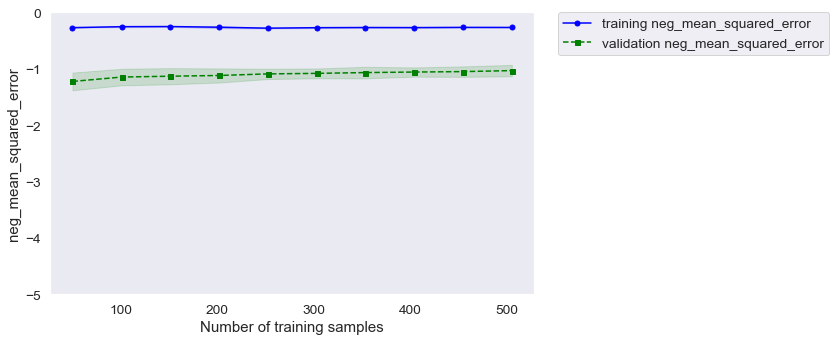

In [355]:
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=final_regressor,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,scoring = 'neg_mean_squared_error',
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(12,5))
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training neg_mean_squared_error')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation neg_mean_squared_error')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('neg_mean_squared_error')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim([-5, 0])
plt.tight_layout()
plt.show()

As can be seen from the learning curve, the optimized Random Forest model has a low bias and a relatively low variance.

 1) Open_x                         0.164876
 2) description_length_Log_x       0.116372
 3) summary_length_Log_x           0.106696
 4) comment_count_Log_x            0.098823
 5) issue_type_New Feature         0.051117
 6) issue_type_Sub-task            0.029851
 7) from_status_Open               0.026836
 8) vote_yes                       0.025583
 9) from_status_Patch Available    0.022323
10) day_Thursday                   0.018925
11) issue_type_Improvement         0.017840
12) who_cutting                    0.017614
13) day_Monday                     0.017508
14) priority_Minor                 0.017262
15) assignee_cutting               0.017250
16) season_spring                  0.016954
17) season_winter                  0.016706
18) assignee_not assigned          0.016579
19) who_rdblue                     0.015137
20) day_Tuesday                    0.014686
21) season_summer                  0.014517
22) priority_Major                 0.014188
23) day_Wednesday               

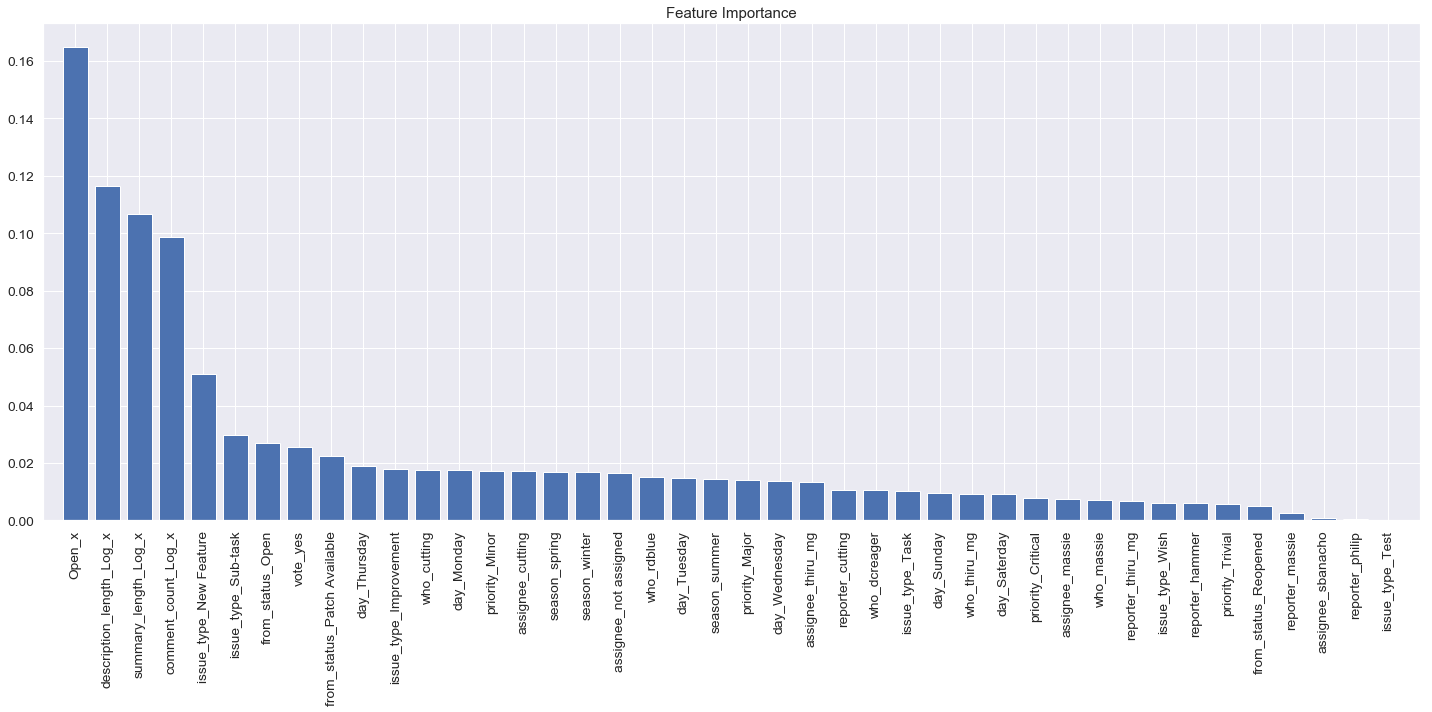

In [469]:
# Feature importance
feat_labels = X.columns

importances = final_regressor.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.figure(figsize=(20,10))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

# Serialize model with pickle

In [470]:
# Get final model
final_regressor

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=80,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [471]:
import pickle
import os

In [472]:
# create directory for the pickled object
dest = os.path.join('issueclassifier','pkl_objects')
if not os.path.exists(dest):
    os.makedirs(dest)

In [473]:
pickle.dump(final_regressor, open(os.path.join(dest, 'final_model_2.pkl'), 'wb'), protocol=4)

In [474]:
# Test pickled object
regressor_unpickled = pickle.load(open(os.path.join('issueclassifier','pkl_objects','final_model_2.pkl'),'rb'))

# Prediction test

In this section we will test the pickled regressor and test it on a random issue in the dataframe.

In [475]:
# Convert just_date to date time
df['just_date'] = pd.to_datetime(df['just_date'])

In [476]:
# Create new column of date created + days existing as a time delta
temp= df['days_existing'].apply(lambda x: pd.Timedelta(x, unit='D'))
df['created+existing'] = df['just_date'] + temp 

In [477]:
df[df['key'] == 'AVRO-2152']

,comment_count_Log_x,summary_length_Log_x,Open_x,description_length_Log_x,from_status_Open,from_status_Patch Available,from_status_Reopened,reporter_cutting,reporter_hammer,reporter_massie,reporter_philip,reporter_thiru_mg,who_cutting,who_dcreager,who_massie,who_rdblue,who_thiru_mg,assignee_cutting,assignee_massie,assignee_not assigned,assignee_sbanacho,assignee_thiru_mg,issue_type_Improvement,issue_type_New Feature,issue_type_Sub-task,issue_type_Task,issue_type_Test,issue_type_Wish,vote_yes,day_Monday,day_Saterday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,season_spring,season_summer,season_winter,priority_Critical,priority_Major,priority_Minor,priority_Trivial,key,resolutiondate,days_existing,just_date,days_in_from_status_Log,created+existing
5,0.231731,0.694185,2.484081,1.228949,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,AVRO-2152,2018-03-05T20:48:34.369+0000,0.0,2018-03-02,1.409179,2018-03-02


In [478]:
# single prediction
example = X_train.loc[5]
example = pd.DataFrame(example)
example = example.T

In [479]:
example

,comment_count_Log_x,summary_length_Log_x,Open_x,description_length_Log_x,from_status_Open,from_status_Patch Available,from_status_Reopened,reporter_cutting,reporter_hammer,reporter_massie,reporter_philip,reporter_thiru_mg,who_cutting,who_dcreager,who_massie,who_rdblue,who_thiru_mg,assignee_cutting,assignee_massie,assignee_not assigned,assignee_sbanacho,assignee_thiru_mg,issue_type_Improvement,issue_type_New Feature,issue_type_Sub-task,issue_type_Task,issue_type_Test,issue_type_Wish,vote_yes,day_Monday,day_Saterday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,season_spring,season_summer,season_winter,priority_Critical,priority_Major,priority_Minor,priority_Trivial
5,0.231731,0.694185,2.484081,1.228949,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [480]:
# prediction based on RF model
prediction_example = regressor_unpickled.predict(example)

In [482]:
prediction_example

array([1.77715435])

In [483]:
# convert back to normal scale
real_pred = np.expm1(prediction_example)

In [484]:
real_pred = real_pred[0]

In [485]:
days = pd.Timedelta(real_pred, unit='D')

In [486]:
predicted_resolutiondate = df[df['key'] == 'AVRO-2152']['created+existing'] + days

In [487]:
predicted_resolutiondate

5   2018-03-06 21:54:43.718400
Name: created+existing, dtype: datetime64[ns]

In [488]:
# Real resolution date
df[df['key'] == 'AVRO-2152']['resolutiondate']

5    2018-03-05T20:48:34.369+0000
Name: resolutiondate, dtype: object

# Set up a SQLite database for the issue dataframe

In [489]:
import sqlite3

In [490]:
if os.path.exists('issues.sqlite'):
    os.remove('issues.sqlite')

In [491]:
conn = sqlite3.connect('issues.sqlite')

In [492]:
conn = sqlite3.connect('issues.sqlite')
df.to_sql('issues_db', conn, if_exists='replace', index=False)
pd.read_sql("select * from issues_db where key = 'AVRO-2169'", conn)

,comment_count_Log_x,summary_length_Log_x,Open_x,description_length_Log_x,from_status_Open,from_status_Patch Available,from_status_Reopened,reporter_cutting,reporter_hammer,reporter_massie,reporter_philip,reporter_thiru_mg,who_cutting,who_dcreager,who_massie,who_rdblue,who_thiru_mg,assignee_cutting,assignee_massie,assignee_not assigned,assignee_sbanacho,assignee_thiru_mg,issue_type_Improvement,issue_type_New Feature,issue_type_Sub-task,issue_type_Task,issue_type_Test,issue_type_Wish,vote_yes,day_Monday,day_Saterday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,season_spring,season_summer,season_winter,priority_Critical,priority_Major,priority_Minor,priority_Trivial,key,resolutiondate,days_existing,just_date,days_in_from_status_Log,created+existing
0,-2.507038,1.13315,2.51949,1.178348,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,AVRO-2169,2018-04-24T06:34:58.762+0000,0.0,2018-04-06 00:00:00,2.928579,2018-04-06 00:00:00


# Create prediction functions

In [493]:
# Function to read issues from database
def read_issue(key):
    row = pd.read_sql("select * from issues_db where key = '{0}'".format(key), conn)
    
    return row

In [494]:
read_issue('AVRO-2169')

,comment_count_Log_x,summary_length_Log_x,Open_x,description_length_Log_x,from_status_Open,from_status_Patch Available,from_status_Reopened,reporter_cutting,reporter_hammer,reporter_massie,reporter_philip,reporter_thiru_mg,who_cutting,who_dcreager,who_massie,who_rdblue,who_thiru_mg,assignee_cutting,assignee_massie,assignee_not assigned,assignee_sbanacho,assignee_thiru_mg,issue_type_Improvement,issue_type_New Feature,issue_type_Sub-task,issue_type_Task,issue_type_Test,issue_type_Wish,vote_yes,day_Monday,day_Saterday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,season_spring,season_summer,season_winter,priority_Critical,priority_Major,priority_Minor,priority_Trivial,key,resolutiondate,days_existing,just_date,days_in_from_status_Log,created+existing
0,-2.507038,1.13315,2.51949,1.178348,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,AVRO-2169,2018-04-24T06:34:58.762+0000,0.0,2018-04-06 00:00:00,2.928579,2018-04-06 00:00:00


## Single issue prediction function 

In [495]:
# Prediction function that reads issues from database
def predictSingleIssue_fromDB(key):
    row = pd.read_sql("select * from issues_db where key = '{0}'".format(key), conn)
    X = row.drop(['days_existing','created+existing','resolutiondate','key','days_in_from_status_Log','just_date'], axis=1)
    prediction = regressor_unpickled.predict(X)
    # convert to real value
    real_value = np.expm1(prediction)
    real_pred = real_value[0]
    days = pd.Timedelta(real_pred, unit='D')
    
    predicted_resolutiondate = df[df['key'] == key]['created+existing'] + days
    
    # Convert datetime64 to string and print only year-month-day
    x = predicted_resolutiondate.values[0]
    ts = pd.to_datetime(str(x)) 
    d = ts.strftime('%Y.%m.%d')
        
    return d

In [496]:
# Example of AVRO-2169
predictSingleIssue_fromDB('AVRO-2169')

'2018.04.16'

In [497]:
# Example of AVRO-417
predictSingleIssue_fromDB('AVRO-417')

'2010.02.19'

## Planning assistance function 

In [498]:
def planningAssistance(nowdate,days_timespan):
    now = pd.to_datetime(nowdate)
    days = pd.Timedelta(days_timespan, unit='D')
    deadline = now + days
    
    # read dataframe from db
    df = pd.read_sql("select * from issues_db", conn)
    # Convert created+existing to date time
    df['created+existing'] = pd.to_datetime(df['created+existing'])
    df['just_date'] = pd.to_datetime(df['just_date'])
    
    X = df.drop(['days_existing','created+existing','resolutiondate','key','days_in_from_status_Log','just_date'], axis=1)
    
    # create new column with predicted resolution date
    predictions = regressor_unpickled.predict(X)
    real_pred = np.expm1(predictions)
    
    # Make dataframe of predictions array
    real_pred = pd.DataFrame(real_pred)
    real_pred = pd.to_timedelta(pd.Series(real_pred[0].values),unit='D')
    real_pred = pd.DataFrame(real_pred,columns=['days_predicted'])
    
    # Merge with dataframe
    df = pd.merge(df, real_pred, left_index=True, right_index=True)
    df['predicted_resolutiondate'] = df['created+existing'] + df['days_predicted']
    df['predicted_resolutiondate'] = df['predicted_resolutiondate'].dt.date
    
    # Filter df where created date is equal or greater than now but less than deadline
    mask = (df['just_date'] >= now) & (df['just_date'] < deadline)
    df = df.loc[mask]
    
    # convert deadline from timestamp to date
    deadline = deadline.date()
    
    # Filter dataframe where predicted_resolutiondate is less or equal to deadline
    df = df[df['predicted_resolutiondate'] < deadline]
     
    return df[['key','predicted_resolutiondate']]

In [499]:
# Example of using the planningAssistance function
planningAssistance('2017-04-06',20)

,key,predicted_resolutiondate
45,AVRO-2025,2017-04-18
46,AVRO-2024,2017-04-17
47,AVRO-2022,2017-04-20
48,AVRO-2018,2017-04-11
